In [ ]:
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

print(tf.__version__)

#### Download MNIST Dataset and split into training and testing

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
print('Train: ', x_train.shape, y_train.shape)
print('Test: ', x_test.shape, y_test.shape)

Train:  (60000, 28, 28) (60000,)
Test:  (10000, 28, 28) (10000,)


#### Count of each digit in the training set

[5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]


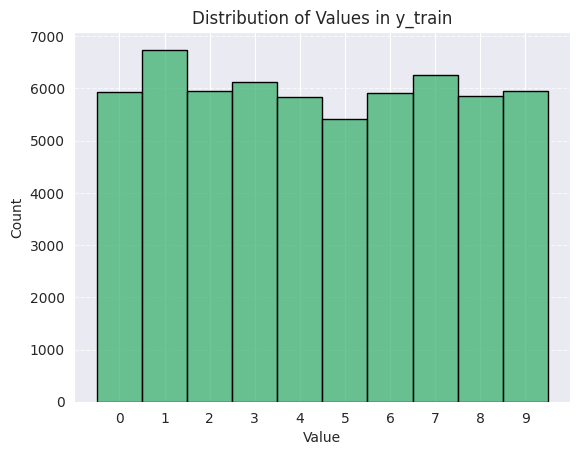

In [4]:
print(np.bincount(y_train))
sns.set_style("darkgrid")
ax = sns.histplot(y_train, bins=np.arange(11) - 0.5, kde=False, color='mediumseagreen', edgecolor='black')
ax.set_xlabel('Value')
ax.set_xticks(range(10))
ax.set_ylabel('Count')
ax.set_title('Distribution of Values in y_train')
ax.grid(axis='y', linestyle='--', alpha=0.7)

#### Check for NaN Values

In [5]:
np.isnan(x_train).any()

False

In [6]:
np.isnan(x_test).any()

False

 #### Normalization and Reshaping

> *source Kaggle*

* The first convolution layer expects a single 60000x28x28x1 tensor instead of 60000 28x28x1 tensors.
* Convert grayscale to binary

In [7]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_train = x_train / 255.0
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
x_test = x_test / 255.0

x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

#### Label Encoding

In [8]:
y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test = tf.one_hot(y_test.astype(np.int32), depth=10)

print(y_train.shape)
print(y_train[0])

(60000, 10)
tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0. 0. 0.], shape=(10,), dtype=float32)


#### Visualize Data

tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)


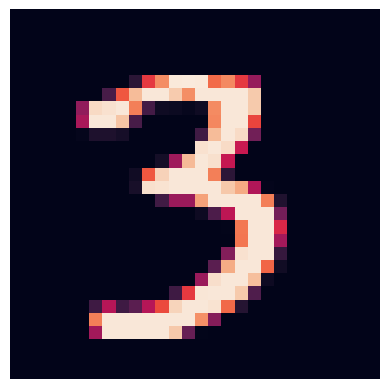

In [9]:
plt.axis('off')
plt.imshow(x_train[10000][:,:,0])
print(y_train[10000])

### Defining the Model

In [10]:
# params

input_shape = (28, 28, 1)
batch_size = 64
num_classes = 10
epochs = 5

`Conv2D` layers are convolutions. Each filter (32 in the first two convolution layers and 64 in the next two convolution layers) transforms a part of the image (5x5 for the first two Conv2D layers and 3x3 for the next two Conv2D layers). The transformation is applied on the whole image.

`MaxPool2D` is a downsampling filter. It reduces a 2x2 matrix of the image to a single pixel with the maximum value of the 2x2 matrix. The filter aims to conserve the main features of the image while reducing the size.

`Dropout` is a regularization layer. In our model, 25% of the nodes in the layer are randomly ignores, allowing the network to learn different features. This prevents overfitting.

`relu` is the rectifier, and it is used to find nonlinearity in the data. It works by returning the input value if the input value >= 0. If the input is negative, it returns 0.

`Flatten` converts the tensors into a 1D vector.

The Dense layers are an artificial neural network (ANN). The last layer returns the probability that an image is in each class (one for each digit).

As this model aims to categorize the images, we will use a `categorical_crossentropy` loss function.

In [11]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape = input_shape),
    tf.keras.layers.Conv2D(32, (5, 5), padding = 'same', activation = 'relu'),
    tf.keras.layers.Conv2D(32, (5, 5), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'),
    tf.keras.layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPool2D(strides = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation = 'softmax')
])

model.compile(optimizer = tf.keras.optimizers.RMSprop(epsilon = 1e-08), loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 484,714 (1.85 MB)

 Trainable params: 484,714 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

#### A callback function that checks if the model has reached the desired accuracy

In [12]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if(logs.get('acc') > 0.995):
      print("\nReached an accuracy of 99.5%, furthur training will not produce any significant gain in accuracy, hence stopping.")
      self.model.stop_training = True

callbacks = myCallback()

In [13]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.1,
                    callbacks=[callbacks])

Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 200s 235ms/step - acc: 0.8499 - loss: 0.4595 - val_acc: 0.9860 - val_loss: 0.0489
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 195s 231ms/step - acc: 0.9770 - loss: 0.0834 - val_acc: 0.9912 - val_loss: 0.0298
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 226s 268ms/step - acc: 0.9838 - loss: 0.0550 - val_acc: 0.9892 - val_loss: 0.0324
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 213s 252ms/step - acc: 0.9874 - loss: 0.0459 - val_acc: 0.9905 - val_loss: 0.0439
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 256s 246ms/step - acc: 0.9878 - loss: 0.0411 - val_acc: 0.9918 - val_loss: 0.0290


#### Evaluate the Model

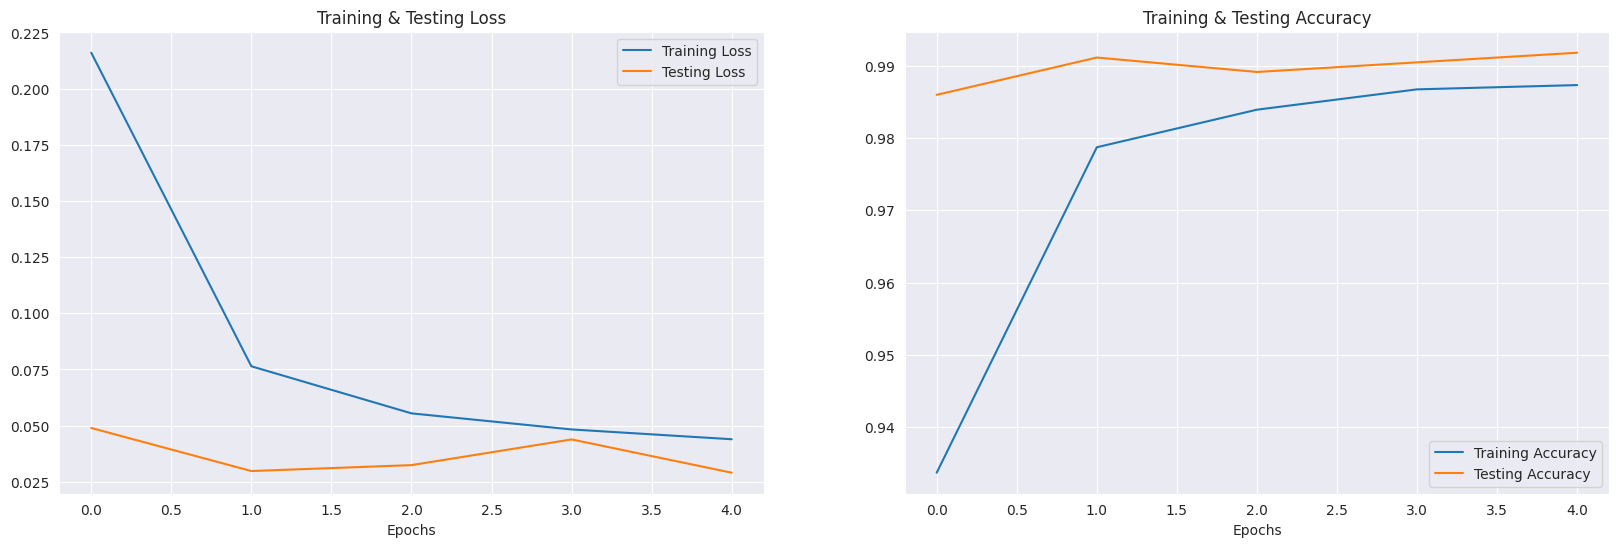

In [14]:
epochs = range(5)
fig, ax = plt.subplots(1, 2)
train_acc = history.history['acc']
train_loss = history.history['loss']
test_acc = history.history['val_acc']
test_loss = history.history['val_loss']

fig.set_size_inches(20, 6)
ax[0].plot(epochs, train_loss, label='Training Loss')
ax[0].plot(epochs, test_loss, label='Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")
plt.grid(axis='y')

ax[1].plot(epochs, train_acc, label='Training Accuracy')
ax[1].plot(epochs, test_acc, label='Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.grid(axis='y')
plt.show()

#### Predict

In [15]:
test_loss, test_acc = model.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - acc: 0.9914 - loss: 0.0271


#### Confusion Matrix

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step


<Axes: >

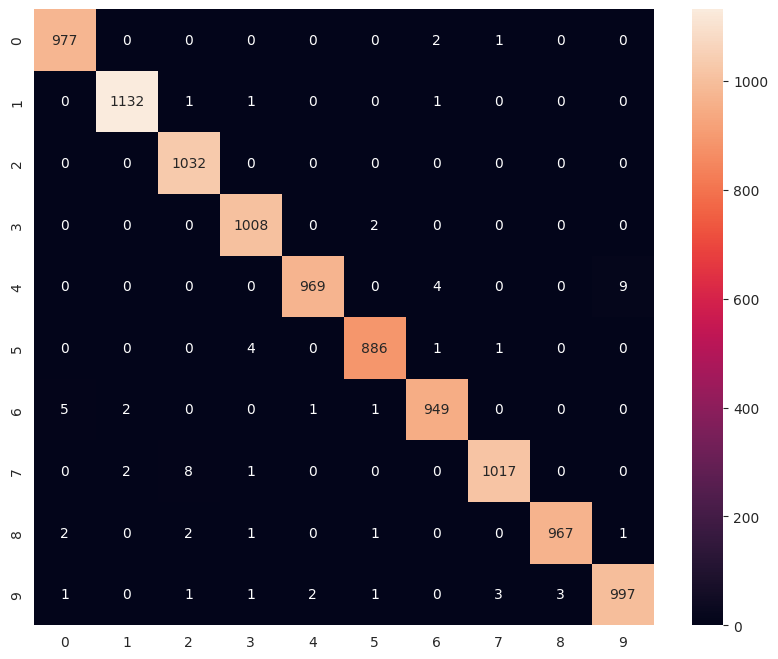

In [16]:
# Predict the values from the testing dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert testing observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1)
# compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_classes) 

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='g')

#### Display Error Results to Compare

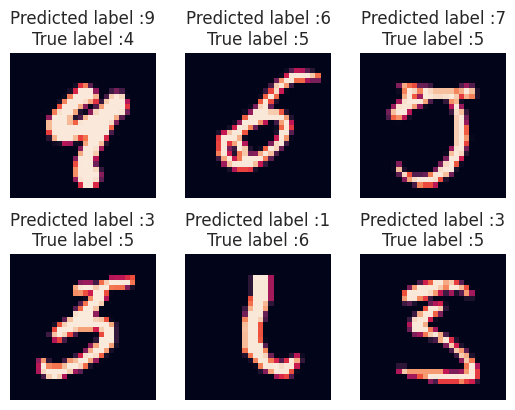

In [17]:
# source https://www.kaggle.com/code/zikazika/theory-and-practice-of-image-processing-cnn

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = x_test[errors]

def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    # This function shows 6 images with their predicted and real labels
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex = True, sharey = True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row, col].axis('off')
            ax[row, col].imshow((img_errors[error]).reshape((28, 28)))
            ax[row, col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error], obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)